# Рекомендация тарифов клиентам сотовой компании

## Описание проекта
Оператору мобильной связи требуется система, анализирующая поведение клиентов на архивных тарифах для предложения им новых тарифов: «Смарт» или «Ультра». Есть данные о клиентах, уже перешедших на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. 

## План работ
1. Открыть файл с данным, изучить его.
2. Разделить исходные данные на обучающую, валидационную и тестовую выборки.
3. Исследовать качество разных моделей, меняя гиперпараметры. Кратко написать выводы исследования.
4. Проверить качество модели на тестовой выборке.
5. Дополнительно: проверить модели на вменяемость. 

## Описание данных
* *сalls* — количество звонков,
* *minutes* — суммарная длительность звонков в минутах,
* *messages* — количество sms-сообщений,
* *mb_used* — израсходованный интернет-трафик в Мб,
* *is_ultra* — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## 1. Открываем и изучаем файл данных

In [1]:
# подгружаем библиотеки
import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import joblib

import matplotlib.pyplot as plt


In [2]:
# читаем датасет
data_users = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
data_users.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [5]:
data_users.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [6]:
# смотрим, сколько пользователей на Ultra и сколько на Smart
data_users['is_ultra'].value_counts()/len(data_users['is_ultra'])

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

### Выводы по шагу 1
Открыли и посмотрели файл с данными:
* Всего 3214 объектов с 4 признаками: количество звонков, длительность звонков, количество СМС, интернет-трафик. 
* Целевой признак, который надо предсказать - тариф, используемый клиентом.
* Пропусков в данных нет, предобработка не требуется.
* Из пользователей, попавших в датасет, 69% используют тариф "Смарт" и 31% использует тариф "Ультра"

## 2. Разбиваем данные на выборки

In [7]:
# делим датасет на обучающую, валидационную, тестовую выборки
data_train, data_test_valid = train_test_split(data_users, test_size=0.4, random_state=12345)
data_valid, data_test = train_test_split(data_test_valid, test_size=0.5, random_state=12345)

In [8]:
print('Размер обучающей выборки:',len(data_train))
print('Размер валидационной выборки:',len(data_test))
print('Размер тестовой выборки:',len(data_valid))

Размер обучающей выборки: 1928
Размер валидационной выборки: 643
Размер тестовой выборки: 643


In [9]:
features_train = data_train.drop(['is_ultra'], axis=1)
target_train = data_train['is_ultra']

features_valid = data_valid.drop(['is_ultra'], axis=1)
target_valid = data_valid['is_ultra']

features_test = data_test.drop(['is_ultra'], axis=1)
target_test = data_test['is_ultra']

### Выводы по шагу 2
1. Разбили датасет на 3 выборки: обучающую, валидационную (проверочную) и тестовую в пропорции 3:1:1. Размеры выборок:
    * обучающей: 1928 объектов;
    * валидационной: 643 объекта;
    * тестовой: 643 объекта.
    
    
2. Для каждой выборки признаки выделили в переменные features_train, features_valid, features_test


3. Целевые признаки каждой выборки выделили в переменные target_train, target_valid, target_test

## 3. Исследуем модели

In [10]:
# у нас задача классификации, потому используем классификационные алгоритмы обучения модели
# обучаем модель на решающем дереве 
# смотрим, при какой глубине дерева получим максимальную долю правильных ответов

fin_accu_tree = 0
fin_depth = 1

for depth in range(1, 26, 1):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train,target_train)
    
    predictions_valid = model_tree.predict(features_valid)
    predictions_valid = pd.Series(predictions_valid, index=features_valid.index)
    accuracy_valid = accuracy_score(target_valid, predictions_valid)
    
    #для визуализации
    if depth == 1:
        tree_list=[[depth,accuracy_valid]]
    else:
        tree_list.append([depth,accuracy_valid])
    
#    print('max_depth:',depth,'accuracy_valid:',accuracy_valid)

    #отбор
    if accuracy_valid > fin_accu_tree:
        fin_accu_tree = accuracy_valid
        fin_depth = depth
        joblib.dump(model_tree, 'model_tree.joblib')
        fin_predictions_tree = predictions_valid
        
print('РЕШАЮЩЕЕ ДЕРЕВО')
print('Максимальная доля правильных ответов для валидационной выборки:',fin_accu_tree,'при глубине дерева:',fin_depth)

РЕШАЮЩЕЕ ДЕРЕВО
Максимальная доля правильных ответов для валидационной выборки: 0.7853810264385692 при глубине дерева: 3


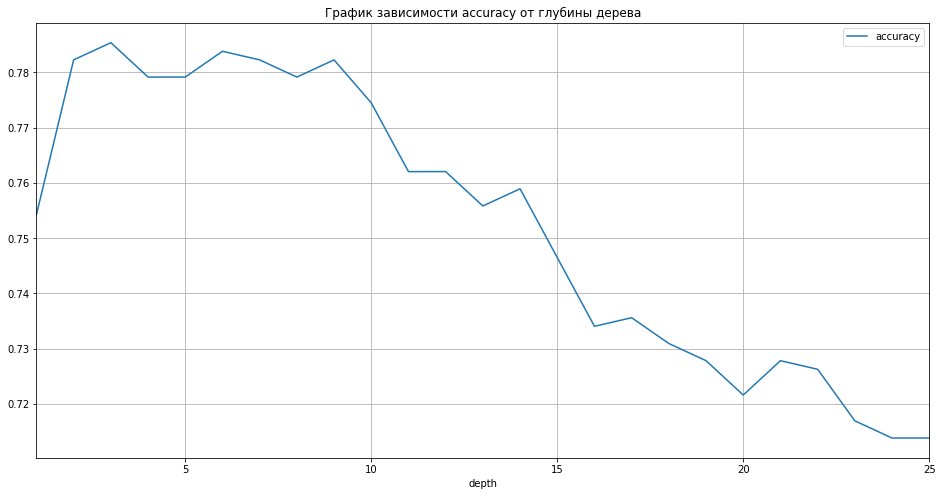

In [11]:
#немного визуализации
data_tree = pd.DataFrame(tree_list,columns=['depth','accuracy'],dtype='float')
data_tree.plot(figsize=(16,8), x = 'depth', y = 'accuracy',grid=True,title='График зависимости accuracy от глубины дерева')

In [12]:
# точность и полнота модели дерева
print('Точность модели решающего дерева:',precision_score(target_valid, fin_predictions_tree, average='binary'))
print('Полнота модели решающего дерева:',recall_score(target_valid, fin_predictions_tree, average='binary'))

Точность модели решающего дерева: 0.7217391304347827
Полнота модели решающего дерева: 0.43915343915343913


In [13]:
#Посмотрим переобучение/недообучение для решающего дерева
model_tree = joblib.load('model_tree.joblib')
predictions_train = model_tree.predict(features_train)
predictions_train = pd.Series(predictions_train, index=features_train.index)
accuracy_train = accuracy_score(target_train, predictions_train)
diff = accuracy_train-fin_accu_tree
print('Решающее дерево: доля правильных ответов для обучающей выборки:',accuracy_train)
if diff > 0:
    print('Модель переобучена')
else:
    if diff < 0:
        print('Модель недообучена')

Решающее дерево: доля правильных ответов для обучающей выборки: 0.8075726141078838
Модель переобучена


In [14]:
# обучаем модель на случайном лесе 
# смотрим, при каком количестве деревьев и глубине дерева получим максимальную долю правильных ответов

fin_accu_forest = 0
fin_estim = 1
fin_depth = 1
for estim in range(1, 46, 1):
    for depth in range(1, 11, 1):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=estim,max_depth=depth)
        model_forest.fit(features_train,target_train)
        predictions_valid = model_forest.predict(features_valid)
        predictions_valid = pd.Series(predictions_valid, index=features_valid.index)
        accuracy_valid = accuracy_score(target_valid, predictions_valid)
        
        #для визуализации
        if depth == 1 and estim == 1:
            forest_list=[[depth,estim,accuracy_valid]]
        else:
            forest_list.append([depth,estim,accuracy_valid])
            
        #print('n_estimators:',estim,'accuracy:',accuracy_valid,'max_depth:',depth)
        if accuracy_valid > fin_accu_forest:
            fin_accu_forest = accuracy_valid
            fin_estim = estim
            fin_depth = depth
            joblib.dump(model_forest, 'model_forest.joblib')
            fin_predictions_forest = predictions_valid

print('СЛУЧАЙНЫЙ ЛЕС')
print('Максимальная доля правильных ответов для валидационной выборки:',fin_accu_forest,'при количестве деревьев:',fin_estim,'и глубине дерева:',fin_depth)

СЛУЧАЙНЫЙ ЛЕС
Максимальная доля правильных ответов для валидационной выборки: 0.8087091757387247 при количестве деревьев: 40 и глубине дерева: 8


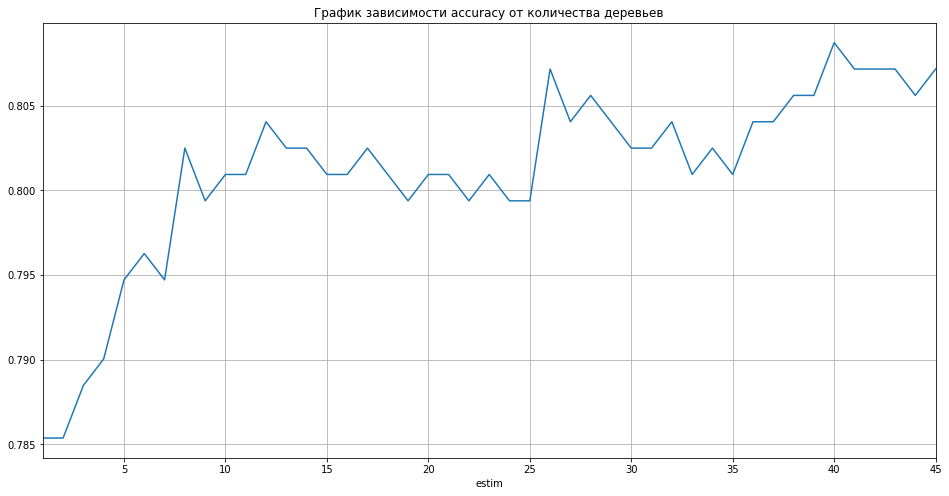

In [15]:
#немного визуализации
data_forest = pd.DataFrame(forest_list,columns=['depth','estim','accuracy'],dtype='float')
data_forest.groupby('estim')['accuracy'].max().plot(figsize=(16,8), x = 'estim', y = 'accuracy',grid=True,title='График зависимости accuracy от количества деревьев')

In [16]:
# точность и полнота модели случайного леса
print('Точность модели случайного леса:',precision_score(target_valid, fin_predictions_forest, average='binary'))
print('Полнота модели случайного леса:',recall_score(target_valid, fin_predictions_forest, average='binary'))

Точность модели случайного леса: 0.775
Полнота модели случайного леса: 0.49206349206349204


In [17]:
#Посмотрим переобучение/недообучение для случайного леса
model_forest = joblib.load('model_forest.joblib')
predictions_train = model_forest.predict(features_train)
predictions_train = pd.Series(predictions_train, index=features_train.index)
accuracy_train = accuracy_score(target_train, predictions_train)
diff = accuracy_train-fin_accu_forest
print('Случайный лес: доля правильных ответов для обучающей выборки:',accuracy_train)
if diff > 0:
    print('Модель переобучена')
else:
    if diff < 0:
        print('Модель недообучена')

Случайный лес: доля правильных ответов для обучающей выборки: 0.875
Модель переобучена


In [18]:
#Выбираем оптимальную модель

if fin_accu_forest >= fin_accu_tree:
    best_model = model_forest #joblib.load('model_forest.joblib')
    title = 'случайный лес'
else:
    best_model = model_tree #joblib.load('model_tree.joblib')
    title = 'решающее дерево'

print('Оптимальная модель:',title)

Оптимальная модель: случайный лес


### Выводы по шагу 3

У нас задача классификации (0/1), потому используем для предсказаний классификационные алгоритмы обучения модели: решающее дерево и случайный лес.
1. Обучили модель model_tree на обучающей выборке с помощью алгоритма "решающее дерево". 
    * Перебором в цикле гиперпараметра "глубина дерева" подобрали оптимальный, при котором при проверке модели на валидной выборке доля правильных ответов (accuracy) будет максимальной. В нашем случае для решающего дерева оптимальной будет глубина дерева, равная 3. В этом случае доля правильных ответов составит 0.785.
    * Помимо доли правильных ответов посчитали другие метрики качества: точность (0.721) и полноту (0.439)
    * Посчитали долю правильных ответов модели на обучающей выборке: 0.807. Модель переобучена.
    
    
2. Обучили модель model_forest на обучающей выборке с помощью алгоритма "случайный лес". 
    * Перебором в циклах гиперпараметров "глубина дерева" и "количество деревьев" подобрали оптимальные, при которых при проверке модели на валидной выборке доля правильных будет максимальной. В нашем случае для случайного леса оптимальными будут количество деревьев, равное 40, и глубина дерева, равная 8. В этом случае доля правильных ответов составит 0.808.
    * Помимо доли правильных ответов посчитали другие метрики качества: точность (0.775) и полноту (0.492)
    * Посчитали долю правильных ответов модели на обучающей выборке: 0.875. Модель переобучена.
    
    
3. Обе модели - и решающее дерево, и случайный лес, удовлетворяют начальному требованию, что accuracy должна быть не менее 0.75. Но модель "случайный лес" более качественная - у нее доля правильных ответов (а также точность и полнота) больше, чем у модели "решающее дерево" (0.808 против 0.785), поэтому для тестовой выборки будем использовать модель "случайный лес". Хоть она и считается более медленной, чем "дерево решений", но в данном проекте у нас нет требований по скорости модели.

## 4. Проверяем модель на тестовой выборке

In [19]:
# проверяем модель на тестовой выборке
predictions_test = best_model.predict(features_test)
predictions_test = pd.Series(predictions_test, index=features_test.index)
accuracy_test = accuracy_score(target_test, predictions_test)
print('Максимальная доля правильных ответов для тестовой выборки:',accuracy_test)

Максимальная доля правильных ответов для тестовой выборки: 0.7962674961119751


In [20]:
# проверка точности и полноты модели на тестовой выборке
print('Точность для тестовой выборки:',precision_score(target_test, predictions_test, average='binary'))
print('Полнота для тестовой выборки:',recall_score(target_test, predictions_test, average='binary'))

Точность для тестовой выборки: 0.75
Полнота для тестовой выборки: 0.5320197044334976


### Выводы по шагу 4
Проверили качество модели "случайный лес" на тестовой выборке. 
Доля правильных ответов составила 0.796, что соответствует начальному требованию (accuracy не менее 0.75). 
Также замерили другие метрики качества: точность (0.75) и полноту (0.532).

## 5. Проверяем модели на адекватность

In [21]:
# Создадим предсказания, где тариф предсказывается случайным образом (1 - Ультра или 0 - Смарт)
predictions_valid_random = pd.Series(np.random.randint(2,size=len(features_valid)), index=features_valid.index)
predictions_valid_random

1386    0
3124    0
1956    0
2286    0
3077    0
       ..
1999    1
1023    0
748     0
1667    0
3197    0
Length: 643, dtype: int64

In [22]:
# Доля правильных ответов для случайной модели для валидной выборки
accuracy_random = accuracy_score(target_valid, predictions_valid_random)
print('Доля правильных ответов для случайной модели для валидной выборки:',accuracy_random)

Доля правильных ответов для случайной модели для валидной выборки: 0.49611197511664074


In [23]:
# Проверяем на адекватность модель решающего дерева
if fin_accu_tree <= accuracy_random:
    print('Наша модель решающего дерева не в адеквате:',fin_accu_tree,'<=',accuracy_random)
else:
    print('Наша модель решающего дерева вполне адекватна:',fin_accu_tree,'>',accuracy_random)

Наша модель решающего дерева вполне адекватна: 0.7853810264385692 > 0.49611197511664074


In [24]:
# Проверяем на адекватность модель случайного леса
if fin_accu_forest <= accuracy_random:
    print('Наша модель случайного леса не в адеквате:',fin_accu_forest,'<=',accuracy_random)
else:
    print('Наша модель случайного леса вполне адекватна:',fin_accu_forest,'>',accuracy_random)

Наша модель случайного леса вполне адекватна: 0.8087091757387247 > 0.49611197511664074


### Выводы по шагу 5
Проверили наши модели на адекватность:
1. Создали предсказания для валидационной выборки случайным образом с помощью генератора случайных чисел (0 - Смарт или 1 - Ультра)
2. Посчитали для случайной модели accuracy (~ 0.5)
3. Сравнили accuracy наших моделей (дерево решений, случайный лес) и случайной. Сравнение оказалось в пользу наших моделей - у них доля правильных ответов больше (0.785 для дерева и 0.808 для леса). Можно считать наши модели более чем адекватными.

## Общие выводы
Все задания проекта выполнены: 
1. Файл с данными открыт и изучен.
2. Исходные данные разделены на обучающую, валидационную и тестовую выборки в пропорции 3:1:1.
3. Исследовано качество разных моделей для классификационной задачи (дерево решений, случайный лес) с различными гиперпараметрами.
4. Выбрана модель с максимальной долей правильных ответов - случайный лес с количеством деревьев 40 и глубиной дерева 8.
5. Качество выбранной модели проверено на тестовой выборке, accuracy = 0.796, что соответствует требованию проекта (accuracy модели должно быть не менее 0.75).
6. Дополнительно проверили модели на вменяемость, сравнив их со случайной моделью. Модели доказали свою адекватность.
7. Выводы по каждому пункту изложены.